In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!unzip '/content/data/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_101.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (3).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_105 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_105 (3).jpg  
  inflating: em

# Human Action Detection using EfficientNetV2

This notebook demonstrates **supervised learning** for human action recognition.

## What is Supervised Learning?
Supervised learning is when we teach a computer by showing it examples with correct answers. Here, we show the model images of people doing different actions (like walking, running, etc.) and tell it what action each image shows. The model learns to recognize these patterns and can predict actions in new images.

## Project Overview
- **Model**: EfficientNetV2 (a powerful pre-trained deep learning model)
- **Task**: Classify human actions from images
- **Method**: Transfer Learning (using a model already trained on millions of images)

## Step 1: Install Required Libraries

Before we start, we need to install some special tools (libraries) that help us work with images and deep learning models.

In [24]:
pip install timm faiss-cpu torch torchvision

## Step 2: Import All Necessary Libraries

Now we'll import (bring in) all the tools we need for our project. Think of this like gathering all your tools before starting a project.

In [ ]:
# Import libraries for data handling and math operations
import numpy as np  # For working with numbers and arrays
import pandas as pd  # For organizing data in tables
import time  # For tracking how long training takes

# Import deep learning libraries
import timm  # Pre-trained models library
import os  # For working with files and folders
import torch  # Main deep learning framework (PyTorch)
import torch.nn as nn  # Neural network building blocks
import torch.nn.functional as F  # Common functions for neural networks
import torch.optim as optim  # Optimization algorithms for training
from torchvision import transforms, datasets  # Tools for image processing
from torch.utils.data import DataLoader  # For loading data in batches
import torchvision  # Computer vision tools

# Import visualization library
import matplotlib.pyplot as plt  # For creating graphs and showing images
import seaborn as sns  # For better statistical visualizations

# Import training utilities
from torch.optim import lr_scheduler  # For adjusting learning rate during training
import copy  # For making copies of model weights

# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report  # For evaluation metrics

## Step 3: Set Up Data Paths

Here we tell the computer where to find our training images. Update these paths to match where your data is stored on your computer.

In [ ]:
# Path to the folder containing our image data
# This folder should have subfolders: train_data and test_data
data_dir = '../content/emirhan_human_dataset/datasets/human_data'

# Path to the labels file (if needed for reference)
labels_dir = '../content/emirhan_human_dataset/datasets/data.txt'

## Step 4: Prepare Data for Training (Data Preprocessing)

In this step, we prepare our images for the model:
- **Training data**: We apply random changes (like flipping, cropping) to make the model learn better
- **Test data**: We only resize and crop to standard size
- **Normalization**: We adjust pixel values to help the model learn faster

This is a key part of supervised learning - we're organizing our labeled data!

In [27]:
# Define how to transform (prepare) our images
data_transforms = {
    'train_data': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip images left-right
        transforms.ToTensor(),  # Convert image to numbers the computer understands
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values
    ]),
    'test_data': transforms.Compose([
        transforms.Resize(256),  # Resize to 256 pixels
        transforms.CenterCrop(224),  # Crop center part to 224x224
        transforms.ToTensor(),  # Convert to numbers
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ]),
}

# Load images from folders and apply transformations
# Each subfolder name becomes a class label (supervised learning!)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_data', 'test_data']}

# Create data loaders to feed images to the model in small batches
# batch_size=4 means we process 4 images at a time
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_data', 'test_data']}

# Count how many images we have for training and testing
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_data', 'test_data']}

# Get the names of action classes (e.g., walking, running, sitting)
class_names = image_datasets['train_data'].classes

# Set device: use GPU if available (faster), otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print information about our dataset
print(f"Training images: {dataset_sizes['train_data']}")
print(f"Testing images: {dataset_sizes['test_data']}")
print(f"Action classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Using device: {device}")

Training images: 15000
Testing images: 3000
Action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Number of classes: 15
Using device: cuda:0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Step 5: Visualize Sample Training Images

Let's look at some example images from our training data to see what the model will learn from.

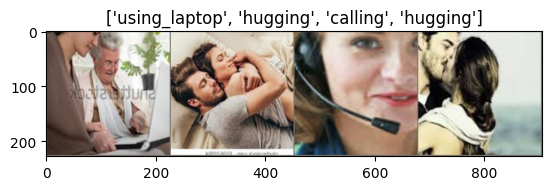

In [ ]:
def imshow(inp, title=None):
    """
    Function to display an image
    - Converts tensor (computer format) back to image format
    - Reverses normalization so colors look normal
    """
    inp = inp.numpy().transpose((1, 2, 0))  # Rearrange dimensions
    mean = np.array([0.485, 0.456, 0.406])  # Mean values used in normalization
    std = np.array([0.229, 0.224, 0.225])   # Standard deviation values
    inp = std * inp + mean  # Reverse the normalization
    inp = np.clip(inp, 0, 1)  # Make sure values are between 0 and 1
    plt.imshow(inp)  # Show the image
    if title is not None:
        plt.title(title)  # Add title if provided
    plt.pause(0.001)  # Brief pause to update display

# Get a batch of training images to display
inputs, classes = next(iter(dataloaders['train_data']))
# Arrange multiple images in a grid
out = torchvision.utils.make_grid(inputs)
# Display the grid with class labels
imshow(out, title=[class_names[x] for x in classes])

## Step 6: Create Training Function (The Heart of Supervised Learning!)

This function teaches the model by:
1. Showing it training images with correct labels (supervision!)
2. Checking its predictions and calculating errors
3. Adjusting the model to make better predictions
4. Testing on separate test data to see real performance

We'll track both **training** and **testing** loss and accuracy to visualize later.

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Main training function for supervised learning

    Parameters:
    - model: The neural network we're training
    - criterion: How we measure prediction errors (loss function)
    - optimizer: Algorithm that adjusts model weights
    - scheduler: Adjusts learning speed over time
    - num_epochs: How many times to go through all training data

    Returns:
    - Trained model with best weights
    - Training history (loss and accuracy for both train and test)
    """
    since = time.time()  # Start timer

    # Save initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store training history for visualization
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Training loop - repeat for specified number of epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training phase and a testing phase
        for phase in ['train_data', 'test_data']:
            if phase == 'train_data':
                model.train()  # Set model to training mode (enables dropout, etc.)
            else:
                model.eval()   # Set model to evaluation mode (disables dropout)

            running_loss = 0.0  # Total loss for this epoch
            running_corrects = 0  # Number of correct predictions

            # Iterate over all batches of data
            for inputs, labels in dataloaders[phase]:
                # Move data to GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Reset gradients from previous step
                optimizer.zero_grad()

                # Forward pass: compute predictions and loss
                # Only track gradients during training
                with torch.set_grad_enabled(phase == 'train_data'):
                    outputs = model(inputs)  # Get model predictions
                    _, preds = torch.max(outputs, 1)  # Get predicted class
                    loss = criterion(outputs, labels)  # Calculate error

                    # Backward pass: adjust weights (only during training)
                    if phase == 'train_data':
                        loss.backward()  # Calculate gradients
                        optimizer.step()  # Update weights

                # Accumulate statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Adjust learning rate after each training epoch
            if phase == 'train_data':
                scheduler.step()

            # Calculate average loss and accuracy for this epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics in history for plotting
            if phase == 'train_data':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['test_loss'].append(epoch_loss)
                history['test_acc'].append(epoch_acc.item())

            # Save model if it's the best so far (based on test accuracy)
            if phase == 'test_data' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Calculate total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Accuracy: {best_acc:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, history

## Step 7: Create Visualization Function for Predictions

This function shows how well our trained model performs on test images by displaying predicted vs actual labels.

In [36]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test_data']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Step 8: Set Up the EfficientNetV2 Model

Now we create our model! We use **transfer learning** - starting with a model that already knows about images, and teaching it specifically about human actions.

**EfficientNetV2** is a powerful but efficient model that works great for image classification.

In [46]:
# Set up the EfficientNetV2 Model
model = timm.create_model("tf_efficientnetv2_s_in21ft1k", pretrained=True, drop_rate=0.3, num_classes=len(class_names))

# Move the model to the specified device (GPU or CPU)
model = model.to(device)

# Define the loss function (Cross-Entropy Loss is suitable for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Stochastic Gradient Descent with momentum)
# This will optimize all parameters of the model
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler
# It will decrease the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


## Step 9: Train the Model (Supervised Learning in Action!)

Time to train! The model will:
1. Look at training images with their correct labels
2. Make predictions
3. Learn from mistakes
4. Get tested on separate test data
5. Repeat for multiple epochs

**This will take some time depending on your computer's power!**

In [47]:
model, history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_data Loss: 1.8873 Acc: 0.4277
test_data Loss: 0.9475 Acc: 0.7073

Epoch 1/9
----------
train_data Loss: 1.3455 Acc: 0.5861
test_data Loss: 0.7941 Acc: 0.7603

Epoch 2/9
----------
train_data Loss: 1.1992 Acc: 0.6275
test_data Loss: 0.7607 Acc: 0.7717

Epoch 3/9
----------
train_data Loss: 1.0831 Acc: 0.6639
test_data Loss: 0.7041 Acc: 0.7987

Epoch 4/9
----------
train_data Loss: 1.0130 Acc: 0.6805
test_data Loss: 0.7301 Acc: 0.7913

Epoch 5/9
----------
train_data Loss: 0.9829 Acc: 0.6953
test_data Loss: 0.6876 Acc: 0.7883

Epoch 6/9
----------
train_data Loss: 0.9303 Acc: 0.7113
test_data Loss: 0.6886 Acc: 0.8007

Epoch 7/9
----------
train_data Loss: 0.8098 Acc: 0.7441
test_data Loss: 0.6308 Acc: 0.8127

Epoch 8/9
----------
train_data Loss: 0.7910 Acc: 0.7477
test_data Loss: 0.6069 Acc: 0.8233

Epoch 9/9
----------
train_data Loss: 0.7666 Acc: 0.7565
test_data Loss: 0.6050 Acc: 0.8177

Training complete in 57m 52s
Best test Accuracy: 0.8233


## Step 10: Visualize Training Results (Loss and Accuracy Graphs)

Now let's see how our model learned over time! We'll create graphs showing:
- **Training vs Test Loss**: Lower is better (means fewer errors)
- **Training vs Test Accuracy**: Higher is better (means more correct predictions)

These graphs help us understand if our supervised learning worked well!

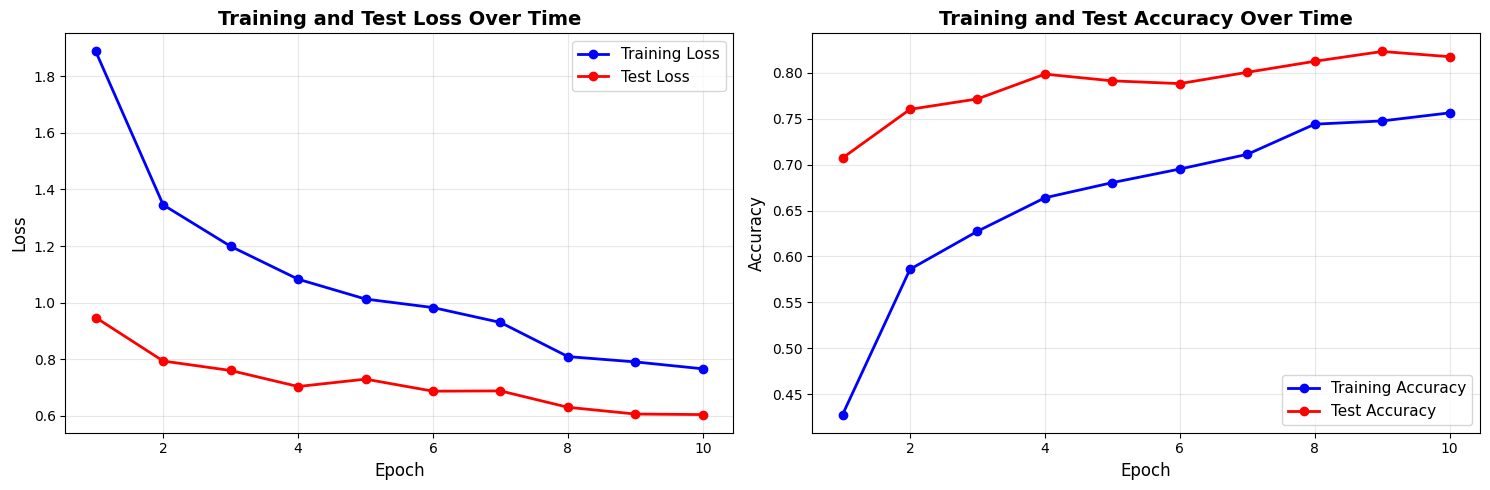


FINAL RESULTS
Final Training Loss: 0.7666
Final Test Loss: 0.6050
Final Training Accuracy: 0.7565 (75.65%)
Final Test Accuracy: 0.8177 (81.77%)


In [48]:
# Create figure with two subplots side by side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training and Test Loss over epochs
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history['test_loss'], 'r-o', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Training and Test Accuracy over epochs
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['test_acc'], 'r-o', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Test Accuracy Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Test Loss: {history['test_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['train_acc'][-1]:.4f} ({history['train_acc'][-1]*100:.2f}%)")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.4f} ({history['test_acc'][-1]*100:.2f}%)")
print("="*60)

## Step 11: Test the Model on Sample Images

Let's see our trained model in action! This will show sample test images with what the model thinks they are.

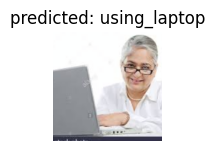

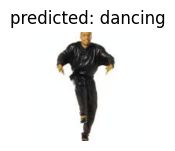

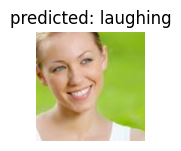

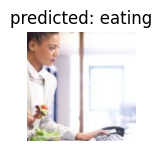

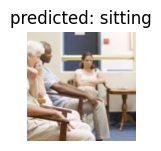

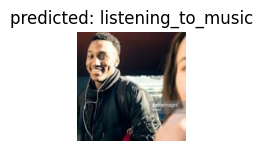

In [50]:
visualize_model(model)

plt.ioff()
plt.show()

## Step 12: Confusion Matrix - Detailed Performance Analysis

A **confusion matrix** shows exactly where the model makes mistakes. It's a table that shows:
- **Rows**: Actual true labels (what the action really is)
- **Columns**: Predicted labels (what the model thinks it is)
- **Diagonal values**: Correct predictions (when actual = predicted)
- **Off-diagonal values**: Mistakes (when the model confused one action for another)

This helps us understand:
- Which actions the model recognizes well
- Which actions get confused with each other
- Where to focus improvements

In [1]:
def compute_confusion_matrix(model, dataloader, device):
    """
    Compute confusion matrix for the model's predictions
    
    Parameters:
    - model: Trained neural network
    - dataloader: Data loader for test/validation set
    - device: CPU or GPU device
    
    Returns:
    - all_preds: All predictions made by the model
    - all_labels: All true labels
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []  # Store all predictions
    all_labels = []  # Store all true labels
    
    print("Computing predictions for confusion matrix...")
    
    # Disable gradient calculation (saves memory and speeds up)
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f"✅ Processed {len(all_labels)} images")
    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Plot confusion matrix as a heatmap
    
    Parameters:
    - cm: Confusion matrix array
    - class_names: List of class names
    - normalize: If True, show percentages instead of counts
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix (Percentages)'
        fmt = '.2%'
    else:
        title = 'Confusion Matrix (Counts)'
        fmt = 'd'
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Predictions' if not normalize else 'Percentage'})
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label (Actual Action)', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label (Model Prediction)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Compute predictions for test data
print("="*60)
print("GENERATING CONFUSION MATRIX")
print("="*60)

all_preds, all_labels = compute_confusion_matrix(model, dataloaders['test_data'], device)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot both versions
print("\n1️⃣ Confusion Matrix with Counts:")
plot_confusion_matrix(cm, class_names, normalize=False)

print("\n2️⃣ Normalized Confusion Matrix (Percentages):")
plot_confusion_matrix(cm, class_names, normalize=True)

GENERATING CONFUSION MATRIX


NameError: name 'model' is not defined

## Step 13: Classification Report - Per-Class Performance Metrics

The classification report shows detailed metrics for each action class:
- **Precision**: When model predicts this action, how often is it correct?
- **Recall**: Of all actual instances of this action, how many did the model find?
- **F1-Score**: Balance between precision and recall (harmonic mean)
- **Support**: Number of actual occurrences of each class in the test set

In [ ]:
# Generate detailed classification report
print("="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print()

# Get classification report as string
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

# Calculate per-class accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

for i, class_name in enumerate(class_names):
    # Get indices where true label is this class
    class_indices = np.where(all_labels == i)[0]
    
    # Count correct predictions for this class
    class_correct = np.sum(all_preds[class_indices] == i)
    class_total = len(class_indices)
    
    # Calculate accuracy
    class_accuracy = (class_correct / class_total * 100) if class_total > 0 else 0
    
    print(f"{class_name:20s}: {class_accuracy:6.2f}% ({class_correct}/{class_total})")

# Overall accuracy
overall_accuracy = np.sum(all_preds == all_labels) / len(all_labels) * 100
print(f"\n{'Overall Accuracy':20s}: {overall_accuracy:6.2f}%")
print("="*60)

## Step 14: Top Confusion Pairs Analysis

This analysis identifies which action pairs the model confuses most often. Understanding these confusions helps us:
- Identify similar actions that need better distinction
- Decide if we need more training data for certain classes
- Understand model limitations

In [ ]:
# Analyze most confused pairs
print("="*60)
print("TOP 10 MOST CONFUSED ACTION PAIRS")
print("="*60)
print()

# Get confusion pairs (excluding diagonal - correct predictions)
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:  # Only misclassifications
            confusion_pairs.append({
                'true_class': class_names[i],
                'predicted_class': class_names[j],
                'count': cm[i, j],
                'percentage': (cm[i, j] / cm[i].sum()) * 100
            })

# Sort by count (most confused pairs first)
confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)

# Display top 10 confusions
print(f"{'True Action':<20} {'→ Predicted As':<20} {'Count':<10} {'% of True Class'}")
print("-" * 70)

for idx, pair in enumerate(confusion_pairs[:10], 1):
    print(f"{pair['true_class']:<20} → {pair['predicted_class']:<20} "
          f"{pair['count']:<10} {pair['percentage']:.2f}%")

if len(confusion_pairs) == 0:
    print("🎉 Perfect! No confusions found!")
elif len(confusion_pairs) < 10:
    print(f"\n(Only {len(confusion_pairs)} confusion pairs found)")

print("\n" + "="*60)

# Visualize top confusions as bar chart
if len(confusion_pairs) > 0:
    top_n = min(10, len(confusion_pairs))
    top_confusions = confusion_pairs[:top_n]
    
    # Prepare data for plotting
    labels = [f"{p['true_class'][:8]}\n→{p['predicted_class'][:8]}" for p in top_confusions]
    counts = [p['count'] for p in top_confusions]
    
    # Create bar chart
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(labels)), counts, color='coral', edgecolor='darkred', linewidth=1.5)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.xlabel('Confusion Pairs (True → Predicted)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Misclassifications', fontsize=12, fontweight='bold')
    plt.title('Top 10 Most Common Misclassification Pairs', fontsize=14, fontweight='bold', pad=15)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=9)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print(f"   The model most often confuses '{confusion_pairs[0]['true_class']}' with '{confusion_pairs[0]['predicted_class']}'")
    print(f"   This happened {confusion_pairs[0]['count']} times ({confusion_pairs[0]['percentage']:.1f}% of all '{confusion_pairs[0]['true_class']}' samples)")
else:
    print("\n🎉 Perfect predictions! No confusion pairs to visualize.")

## Summary: Understanding the Results

### What is Supervised Learning?
In this notebook, we used **supervised learning** - teaching a computer by showing it examples with correct answers (labels). Each image in our dataset had a label telling what action was shown (like "walking" or "running").

### Key Metrics Explained:

**Loss (Error):**
- Measures how wrong the model's predictions are
- Lower values = better performance
- Training loss shows errors on data the model learns from
- Test loss shows errors on new, unseen data (more important!)

**Accuracy:**
- Percentage of correct predictions
- Higher values = better performance
- Test accuracy is the true measure of how well the model learned

**Confusion Matrix:**
- Shows exactly which actions the model confuses
- Diagonal values = correct predictions (high is good!)
- Off-diagonal values = mistakes (low is good!)
- Helps identify similar actions that need better distinction

**Classification Report Metrics:**
- **Precision**: When model predicts an action, how often is it right?
- **Recall**: Of all actual instances, how many did model catch?
- **F1-Score**: Balance between precision and recall
- **Support**: Number of test samples for each class

### What to Look For:

✅ **Good Signs:**
- Test accuracy increases over time
- Test loss decreases over time
- Training and test metrics are close (model generalizes well)
- High diagonal values in confusion matrix
- Balanced precision and recall across classes

⚠️ **Warning Signs:**
- Big gap between training and test accuracy = overfitting (model memorized instead of learned)
- Test accuracy not improving = model not learning well
- Both accuracies very low = need better model or more data
- High off-diagonal values = model confusing specific actions
- Low recall for certain classes = need more training data

### How to Use Confusion Matrix:
1. **Check diagonal**: High values = good performance for that class
2. **Check off-diagonal**: High values = confusion between classes
3. **Identify patterns**: Which actions get confused most?
4. **Take action**: Collect more data for confused classes or use better features

### Next Steps Based on Analysis:
- **If overall accuracy is low**: Train longer or try different model
- **If specific classes perform poorly**: Collect more data for those classes
- **If two classes are confused**: They may be too similar; need better features
- **If overfitting occurs**: Add more dropout or data augmentation
- Try different number of epochs
- Adjust learning rate
- Use more advanced data augmentation
- Consider ensemble methods for better accuracy